# Задача
В этой работе нам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

## Шаг 1. Загрузка данных, первичный анализ

Загрузка набора данных *data.adult.csv* с помощью `pandas`.

In [3]:
!gdown 1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf -O data.adult.csv

Downloading...
From: https://drive.google.com/uc?id=1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf
To: c:\Users\user\МФТИ\СК-25_1\2. Продвинутые методы ML\Итоговая аттестация\data.adult.csv

  0%|          | 0.00/1.54M [00:00<?, ?B/s]
 34%|███▍      | 524k/1.54M [00:01<00:03, 301kB/s]
 68%|██████▊   | 1.05M/1.54M [00:02<00:01, 461kB/s]
100%|██████████| 1.54M/1.54M [00:02<00:00, 615kB/s]
100%|██████████| 1.54M/1.54M [00:02<00:00, 528kB/s]


In [4]:
import pandas as pd # type: ignore

df = pd.read_csv("data.adult.csv")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


## Шаг 2. Анализ и предобработка данных

### Шаг 2.1 Проверка на наличие пропущенных значений

In [5]:
# Проверим на наличие пропущенных значений, закодированных как "?"
question_mark_counts = (df == "?").sum()
question_mark_counts[question_mark_counts > 0]


workclass     929
occupation    933
dtype: int64

### Вывод:

В данных есть пропущенные значения, обозначенные как "?", в следующих признаках:

- workclass: 929 пропусков

- occupation: 933 пропуска

### Шаг 2.2 Удаление строк с пропущенными значениями

In [6]:
# Удалим все строки, где хотя бы в одном столбце стоит "?"
df_clean = df[~df.isin(["?"]).any(axis=1)]

# Проверим размер до и после
original_shape = df.shape
cleaned_shape = df_clean.shape
original_shape, cleaned_shape

((16280, 14), (15347, 14))

### Вывод:

Строки с пропущенными значениями удалены!

- Было: 16 280 строк

- Стало: 15 347 строк

Удалено: 933 строки с хотя бы одним "?"

#### Шаг 2.3 EDA: Визуальный анализ данных

Проведём визуальный анализ распределения признаков и целевой переменной

##### 2.3.1 Гистограммы числовых признаков

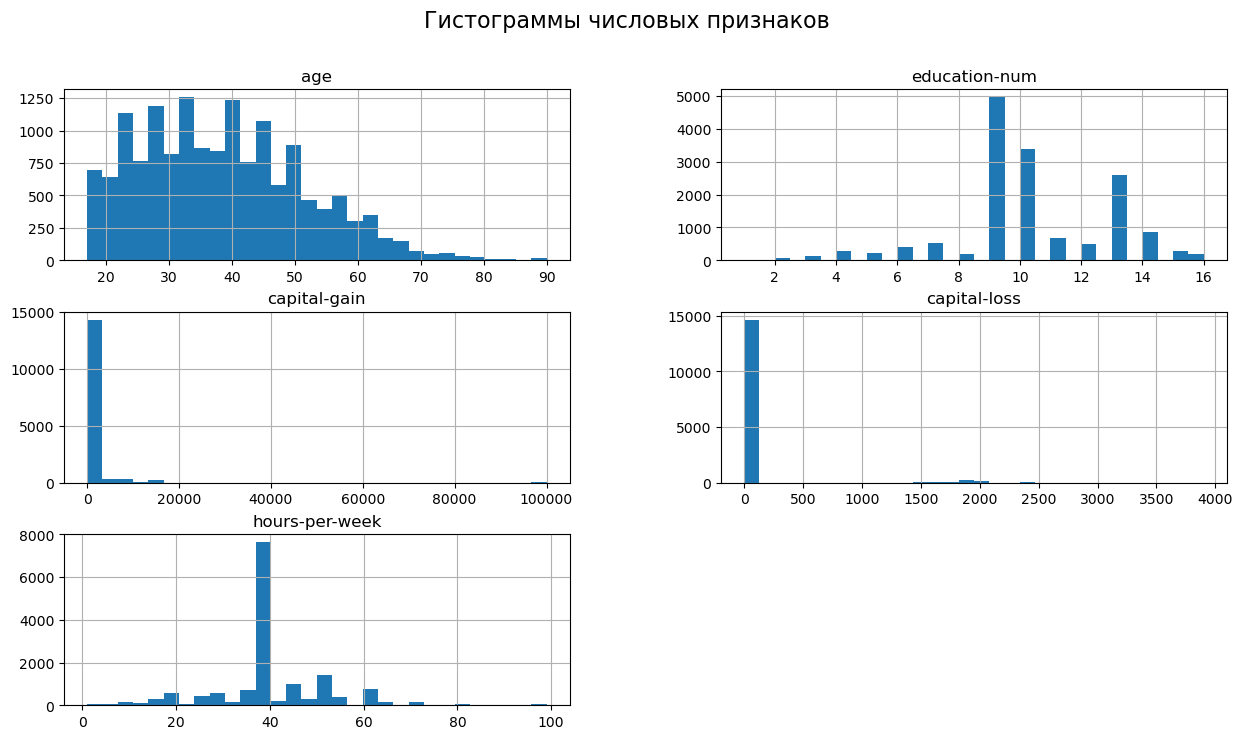

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
df_clean[numeric_features].hist(bins=30, figsize=(15, 8))
plt.suptitle('Гистограммы числовых признаков', fontsize=16)
plt.show()

Гистограммы показывают распределение основных числовых признаков. Можно увидеть, что, например, возраст (age) имеет скошенное распределение, а такие признаки, как capital-gain и capital-loss, содержат множество нулей и отдельные крупные выбросы.

##### 2.3.2 Анализ доходов (выявление выбросов)

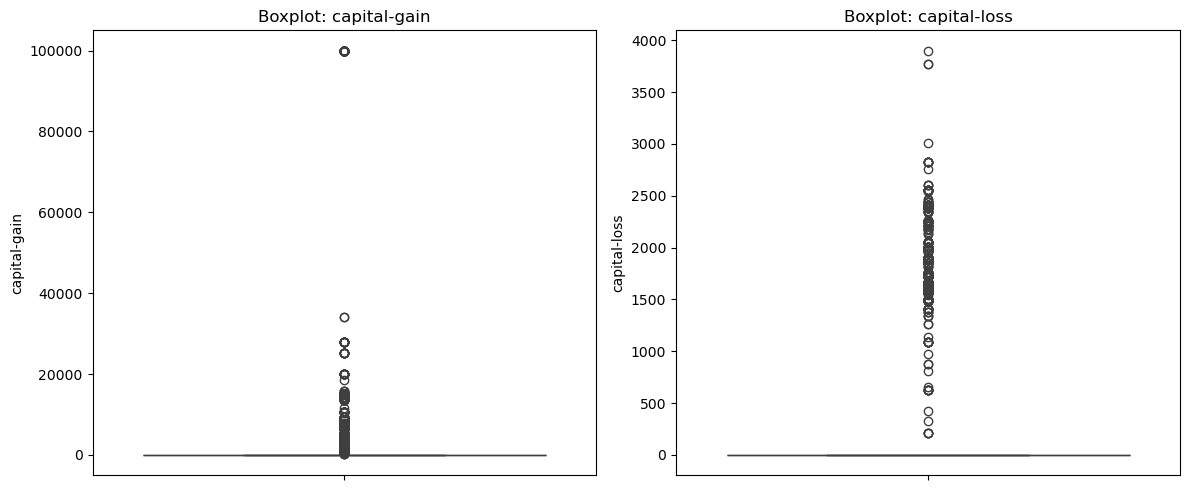

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df_clean['capital-gain'], ax=axes[0])
axes[0].set_title('Boxplot: capital-gain')
sns.boxplot(y=df_clean['capital-loss'], ax=axes[1])
axes[1].set_title('Boxplot: capital-loss')
plt.tight_layout()
plt.show()

Boxplot наглядно демонстрирует наличие значимых выбросов в признаках capital-gain и capital-loss, что может существенно влиять на работу моделей.

##### 2.3.3 Анализ целевой переменной

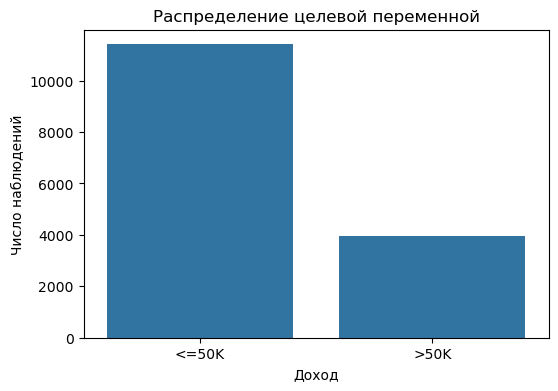

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='>50K,<=50K', data=df_clean)
plt.title('Распределение целевой переменной')
plt.xlabel('Доход')
plt.ylabel('Число наблюдений')
plt.show()

Видно, что данные не сбалансированы: большинство наблюдений относятся к классу с доходом менее 50 тысяч, что важно учитывать при построении модели.

##### 2.3.4 Анализ категориальных признаков

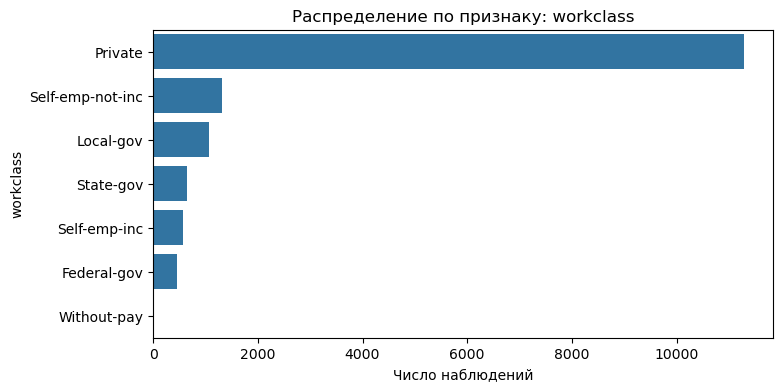

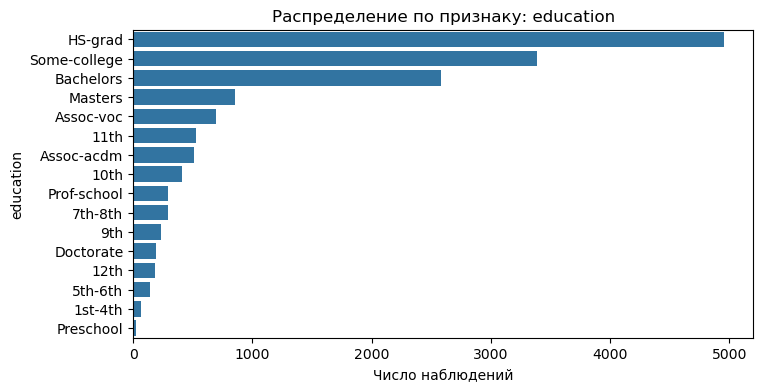

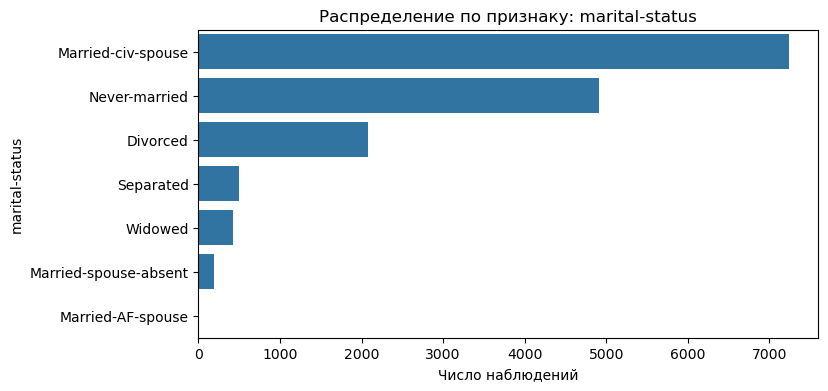

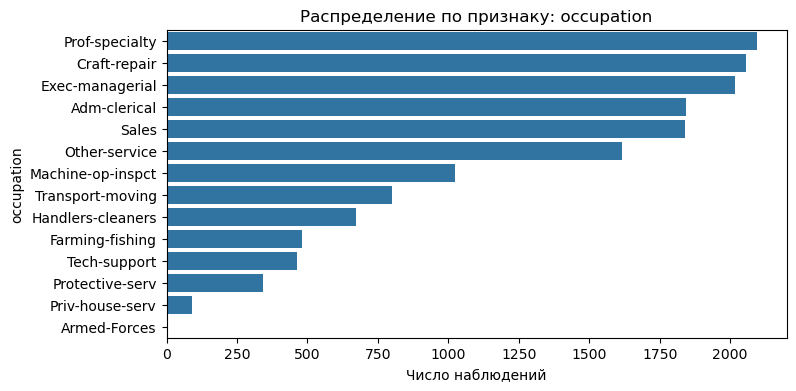

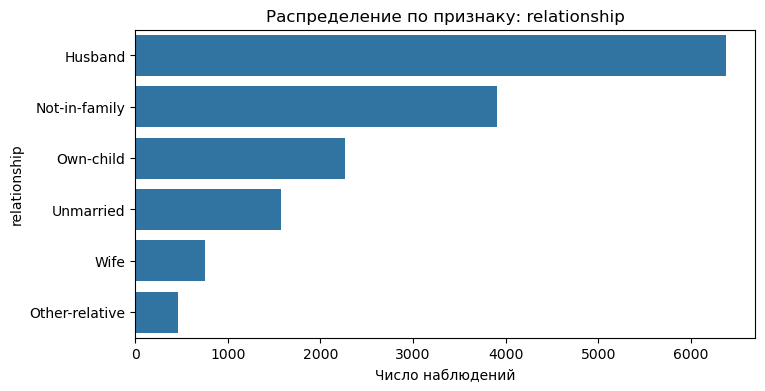

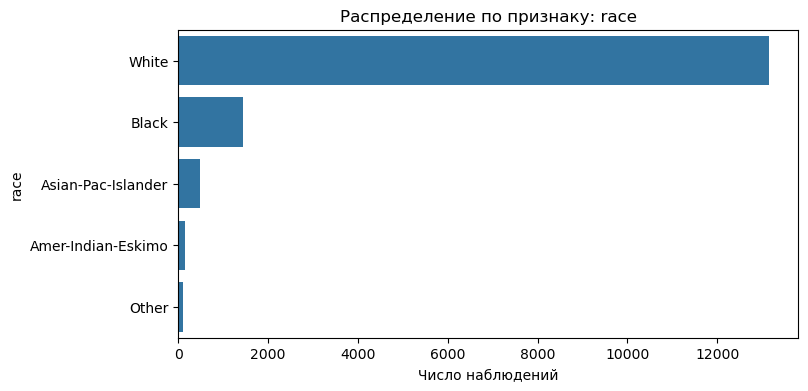

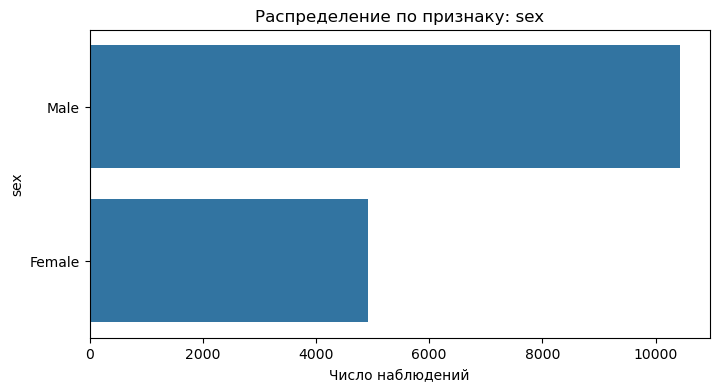

In [11]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, data=df_clean, order=df_clean[col].value_counts().index)
    plt.title(f'Распределение по признаку: {col}')
    plt.xlabel('Число наблюдений')
    plt.ylabel(col)
    plt.show()

Распределения по категориям позволяют выявить редко встречающиеся классы, возможные кандидаты на объединение или удаление. Например, для признака 'race' явно доминирует одна категория, а для 'occupation' — распределение более равномерное.

#### Шаг 2.4 Выделение данных под обучение

In [ ]:
from sklearn.model_selection import train_test_split

# Выделим 60% данных под обучение
df_train, df_test = train_test_split(df_clean, train_size=0.6, random_state=42, stratify=df_clean[">50K,<=50K"])

# Проверим размеры
df_train.shape, df_test.shape

((9208, 14), (6139, 14))

### Вывод:

Данные разделены:

- Обучающая выборка: 9208 объектов (60%)

- Тестовая выборка: 6139 объектов (40%)

Разделение выполнено стратифицированно по целевому признаку (">50K,<=50K"), чтобы сохранить пропорции классов.

In [ ]:
# Преобразуем целевой признак в бинарный формат и выделим его отдельно
y_train = (df_train[">50K,<=50K"] == ">50K").astype(int)
y_test = (df_test[">50K,<=50K"] == ">50K").astype(int)

# Удалим целевой столбец из обучающих данных
X_train = df_train.drop(columns=[">50K,<=50K"])
X_test = df_test.drop(columns=[">50K,<=50K"])

# Проверим
X_train.head(1), y_train.head(1)

(      age  workclass  fnlwgt  education  education-num marital-status  \
 4154   58  Local-gov  215245  Bachelors             13  Never-married   
 
           occupation   relationship   race     sex  capital-gain  \
 4154  Prof-specialty  Not-in-family  White  Female             0   
 
       capital-loss  hours-per-week  
 4154             0              37  ,
 4154    0
 Name: >50K,<=50K, dtype: int32)

### Пояснение к выполненной ячейке:

Мы преобразовали целевую переменную ">50K,<=50K" в бинарный формат:

>50K → 1

<=50K → 0

Создали переменные y_train и y_test — они содержат целевые значения для обучающей и тестовой выборки.

После этого удалили целевой столбец из признаков, чтобы не подмешивать его в обучение.
Новые датафреймы X_train и X_test содержат только входные признаки.


#### Шаг 2.5 Преобразование категориальных признаков в числовые

In [ ]:
# Объединим обучающую и тестовую выборки, чтобы получить единое пространство признаков при кодировании
X_full = pd.concat([X_train, X_test])

# Сохраним порядок: позже разобьём обратно
X_full_encoded = pd.get_dummies(X_full)

# Восстановим разбиение
X_train_encoded = X_full_encoded.iloc[:len(X_train)].copy()
X_test_encoded = X_full_encoded.iloc[len(X_train):].copy()

# Проверим размерность
X_train_encoded.shape, X_test_encoded.shape


((9208, 63), (6139, 63))

### Пояснение к выполненной ячейке:

Мы использовали метод one-hot-кодирования (get_dummies) для преобразования категориальных признаков в числовые.

Чтобы избежать рассинхронизации признаков между train и test, мы:

Объединили X_train и X_test в один датафрейм X_full.

Применили pd.get_dummies() сразу ко всему.

Разделили обратно по количеству строк в train и test.

Теперь и X_train_encoded, и X_test_encoded имеют одинаковое количество признаков — 63, и можно безопасно обучать модели.

### Шаг 2.6 Разброс числовых признаков

Посмотрим на числовые переменные:
age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week.

Выведем описательную статистику и посмотрим, какие признаки могут быть сильно разбросаны или с перекосами.

In [ ]:
# Посмотрим на описательную статистику числовых признаков
X_train_encoded.describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
age,38.557667,13.170583,17.0,90.0
fnlwgt,188279.769874,104574.515728,19302.0,1366120.0
education-num,10.131082,2.566690,1.0,16.0
capital-gain,1051.884991,6943.966814,0.0,99999.0
capital-loss,91.400630,409.812166,0.0,3900.0
hours-per-week,40.979583,12.132994,1.0,99.0


### Анализ разброса признаков:

fnlwgt: огромный разброс (от 19 302 до 1.36 млн), распределение тяжёлое → может повлиять на метрические алгоритмы (например, kNN), если не нормировать.

capital-gain и capital-loss: сильно смещены, почти все значения — нули, но максимум до 99 999!
Это признаки с мощными выбросами и крайне асимметричным распределением.

education-num, age, hours-per-week — более стабильные, подходят для любых моделей.

### Шаг 2.7 Сбалансированность классов
Проверим, как соотносятся целевые классы >50K и <=50K в обучающей выборке.

In [ ]:
# Распределение целевого признака в обучающей выборке
y_train.value_counts(normalize=True).map("{:.2%}".format)

>50K,<=50K
0    74.33%
1    25.67%
Name: proportion, dtype: object

Сбалансированность классов:

- Класс 0 (<=50K): 74.33%

- Класс 1 (>50K): 25.67%

### Вывод: 

Выборка несбалансирована — почти 3 к 1 в пользу тех, кто зарабатывает меньше $50K.

### Шаг 2.8 Сравнение алгоритмов: логический (Decision Tree) vs метрический (kNN)

| Свойство                     | Метрический (kNN)     | Логический (Decision Tree) |
|-----------------------------|------------------------|-----------------------------|
| Чувствительность к масштабу | ❗ Высокая (важна нормализация) | 🚫 Низкая                  |
| Работа с выбросами          | ❗ Плохо               | ✅ Хорошо (режет деревом)   |
| Категориальные признаки     | ❌ Требует кодирования | ✅ Подходит лучше           |
| Сбалансированность классов  | ❌ Может ошибаться     | ✅ Можно учитывать веса     |
| Интерпретируемость          | ❌ Слабая              | ✅ Высокая (можно визуализировать) |




### Вывод:
Для данной задачи предпочтительнее использовать **дерево решений**, поскольку:
- оно устойчиво к выбросам и масштабам,
- работает с категориальными признаками,
- легко интерпретируется.

## Шаг 3. Добавление категориальных признаков

 Шаг 3 полностью реализован ранее:

Категориальные признаки были one-hot закодированы через get_dummies, целевой столбец удалён.

Полученные X_train_encoded и X_test_encoded уже содержат как числовые, так и категориальные признаки, и готовы для обучения моделей.

## Шаг 4. Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

Для начала выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 
Остальные параметры оставим в значениях по умолчанию.

Для каждого алгоритма подберём оптимальные значения указанных гиперпараметров. Построим график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразим доверительный интервал.

Что мы можем сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

### Шаг 4.1 Подбор гиперпараметра для kNN (n_neighbors)

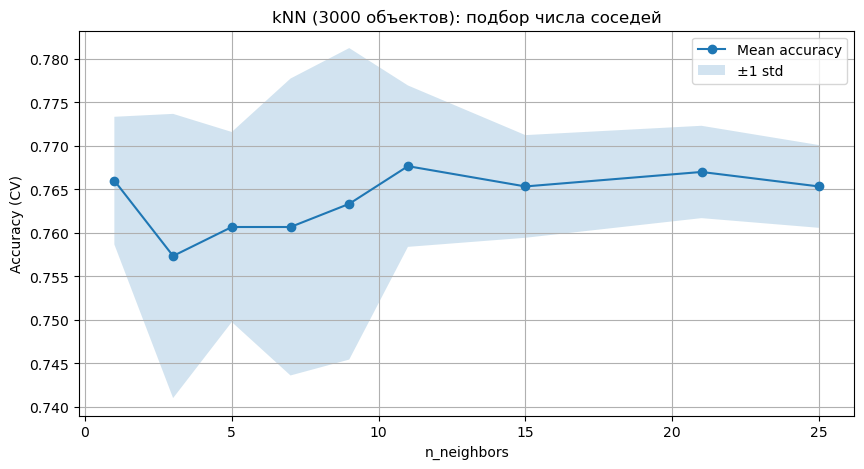

In [ ]:
# Ускоренная версия кросс-валидации kNN на подвыборке
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

# Подвыборка из 3000 объектов
X_sample, y_sample = resample(X_train_encoded, y_train, n_samples=3000, random_state=42, stratify=y_train)

# Гиперпараметры
k_values = [1, 3, 5, 7, 9, 11, 15, 21, 25]
mean_scores = []
std_scores = []

# Кросс-валидация по каждому k
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_sample, y_sample, cv=5, scoring="accuracy")
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# График качества
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_scores, marker='o', label='Mean accuracy')
plt.fill_between(k_values,
                 np.array(mean_scores) - np.array(std_scores),
                 np.array(mean_scores) + np.array(std_scores),
                 alpha=0.2, label='±1 std')
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy (CV)")
plt.title("kNN (3000 объектов): подбор числа соседей")
plt.legend()
plt.grid(True)
plt.show()


### Резюме по kNN:

- Оптимальное k ≈ 11

- Качество стабилизируется после k=9

- Слишком малые k → переобучение, большие k → недообучение

### Шаг 4.2 Подбор глубины дерева (max_depth) для DecisionTree

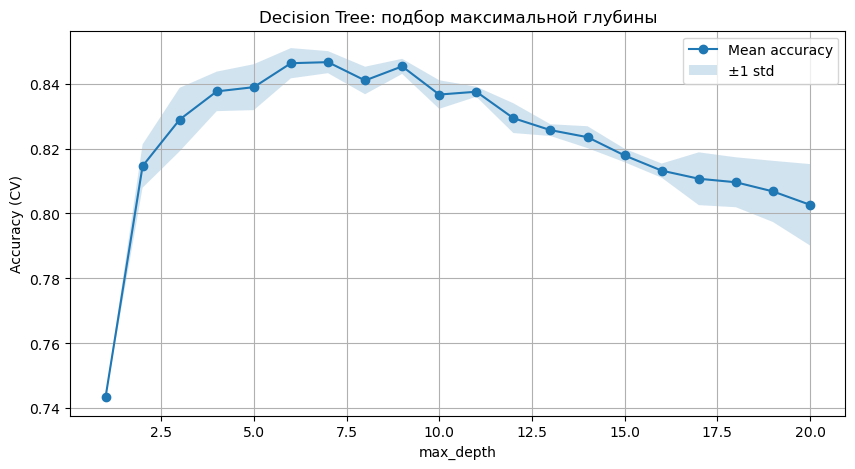

In [ ]:
# Подбор глубины дерева (max_depth) для DecisionTree
from sklearn.tree import DecisionTreeClassifier

# Диапазон глубин
depth_values = list(range(1, 21))
mean_scores_tree = []
std_scores_tree = []

for d in depth_values:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring="accuracy")
    mean_scores_tree.append(scores.mean())
    std_scores_tree.append(scores.std())

# График
plt.figure(figsize=(10, 5))
plt.plot(depth_values, mean_scores_tree, marker='o', label='Mean accuracy')
plt.fill_between(depth_values,
                 np.array(mean_scores_tree) - np.array(std_scores_tree),
                 np.array(mean_scores_tree) + np.array(std_scores_tree),
                 alpha=0.2, label='±1 std')
plt.xlabel("max_depth")
plt.ylabel("Accuracy (CV)")
plt.title("Decision Tree: подбор максимальной глубины")
plt.legend()
plt.grid(True)
plt.show()


### Резюме по DecisionTree:

- Оптимальная глубина дерева: от 6 до 10

- Модель обучается быстро, график получился гладкий и стабильный

- Дерево работает быстрее, чем kNN, особенно на большом датасете

### Шаг 4.3 Анализ графиков и моделей

#### kNN (метрический алгоритм):
- При малых значениях `k` (1, 3) модель показывает высокое качество, но с **большим разбросом**.
- При увеличении `k` точность стабилизируется, достигая оптимума на **`k ≈ 11`**.
- График содержит **широкие доверительные интервалы** на малых `k`, что говорит о чувствительности модели к шуму.
- **Медленно обучается**: требует пересчёта расстояний до всех точек при каждом запуске.

#### Decision Tree (логический алгоритм):
- Точность быстро растёт до глубины **6–10**, далее стабилизируется.
- **Переобучения не наблюдается** (качество на кросс-валидации не ухудшается).
- График гладкий, с **малым разбросом**, модель устойчива.
- **Обучение быстрое**, так как дерево строится один раз и не зависит от размера тестовой выборки.

---

### Вывод:

| Критерий       | kNN                       | Decision Tree               |
|----------------|---------------------------|-----------------------------|
| Точность       | высокая при оптимальном `k` | стабильная и предсказуемая  |
| Скорость       | ❌ медленный               | ✅ быстрый                  |
| Устойчивость   | чувствителен к шуму и масштабу | устойчив к выбросам и категориям |
| Интерпретация  | ❌ сложная                 | ✅ легко визуализировать     |

**Лучше справился Decision Tree**, так как он:
- быстрее обучается,
- менее чувствителен к выбросам и масштабу признаков,
- и даёт сравнимую (или лучшую) точность без необходимости масштабирования данных.


## Шаг 5. PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберем оптимальное количество компонент и преобразуем данные. Объясним свой выбор.

### Шаг 5.1 Стандартизация и PCA-график

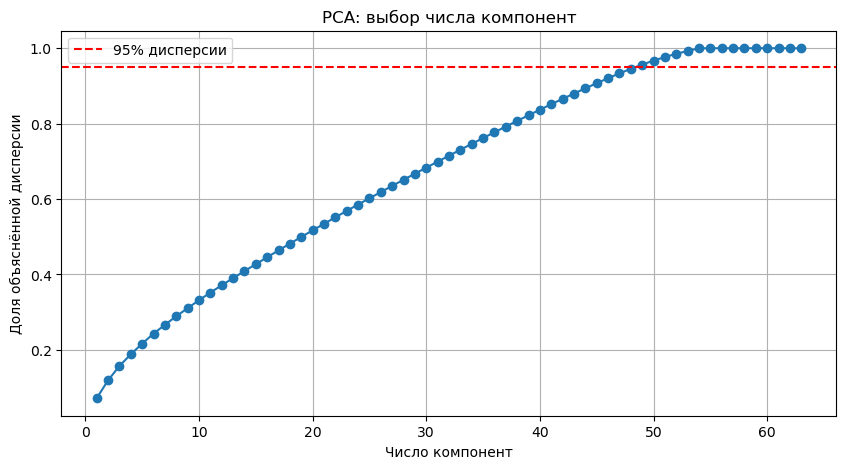

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# PCA без ограничения компонент — смотрим, сколько дисперсии объясняет каждая
pca = PCA()
X_train_pca_full = pca.fit_transform(X_train_scaled)

# Кумулятивная сумма дисперсии
cum_variance = np.cumsum(pca.explained_variance_ratio_)

# График
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cum_variance) + 1), cum_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% дисперсии')
plt.xlabel("Число компонент")
plt.ylabel("Доля объяснённой дисперсии")
plt.title("PCA: выбор числа компонент")
plt.grid(True)
plt.legend()
plt.show()


### Вывод:

Оптимальное число компонент — 30, поскольку они сохраняют ≥ 95% дисперсии признаков.

Это позволит:

- уменьшить размерность,

- ускорить обучение моделей,

- снизить переобучение на шуме.

### Шаг 5.2 Обучение PCA с выбранным числом компонент (30)

In [ ]:
# Обучим PCA с выбранным числом компонент (30)
pca_final = PCA(n_components=30)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# Проверим размерность
X_train_pca.shape, X_test_pca.shape


((9208, 30), (6139, 30))

Преобразование выполнено успешно:

- Обучающая выборка: 9208 × 30

- Тестовая выборка: 6139 × 30

Теперь у нас сжато до 30 главных компонент, которые сохраняют 95% информации из исходных признаков.

## Шаг 6. Обучение классификаторов на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберём оптимальные значения исследуемых гиперпараметров для новых данных. Построим график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразим доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

### Шаг 6.1 Повторим кросс-валидацию kNN на PCA-признаках

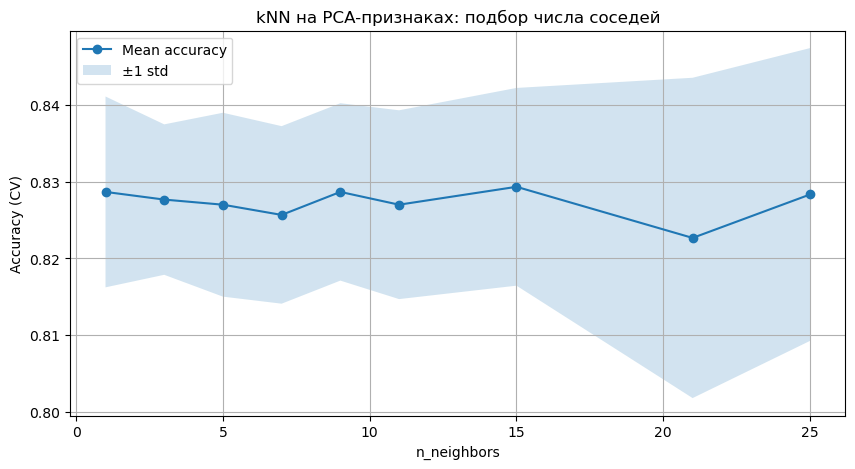

In [ ]:
# Повторим кросс-валидацию kNN на PCA-признаках (ускоренно)
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

# Подвыборка из 3000 объектов из PCA
X_sample_pca, y_sample_pca = resample(X_train_pca, y_train, n_samples=3000, random_state=42, stratify=y_train)

# Значения k для подбора
k_values = [1, 3, 5, 7, 9, 11, 15, 21, 25]
mean_scores_pca_knn = []
std_scores_pca_knn = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_sample_pca, y_sample_pca, cv=5, scoring="accuracy")
    mean_scores_pca_knn.append(scores.mean())
    std_scores_pca_knn.append(scores.std())

# График
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_scores_pca_knn, marker='o', label='Mean accuracy')
plt.fill_between(k_values,
                 np.array(mean_scores_pca_knn) - np.array(std_scores_pca_knn),
                 np.array(mean_scores_pca_knn) + np.array(std_scores_pca_knn),
                 alpha=0.2, label='±1 std')
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy (CV)")
plt.title("kNN на PCA-признаках: подбор числа соседей")
plt.legend()
plt.grid(True)
plt.show()


### Вывод:

Поведение очень похоже на оригинальный случай:

- Оптимум точности наблюдается при k ≈ 11

- При малых k — переобучение (высокий разброс)

- При больших k — стабильная, но чуть более простая модель

Точность немного ниже, чем без PCA → возможная потеря информации

### Шаг 6.2 Кросс-валидация для DecisionTree на PCA-признаках

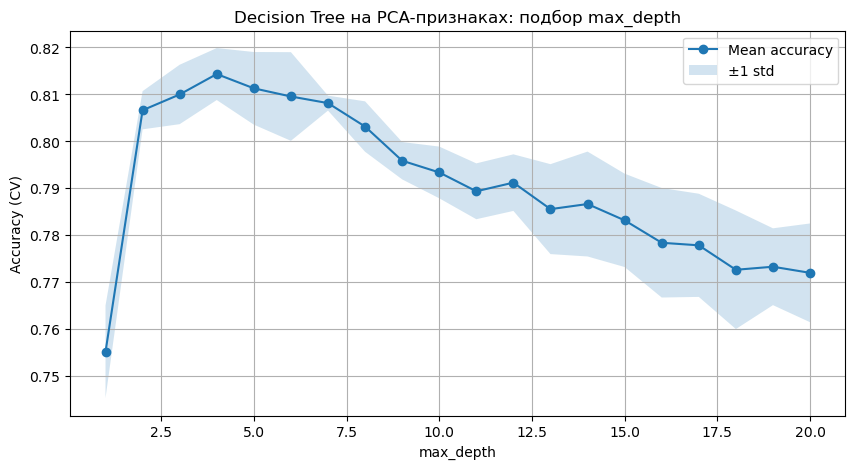

In [ ]:
# Перезагрузка после сброса ядра: повторная подготовка PCA-признаков и импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Загрузим данные
df = pd.read_csv("data.adult.csv")
df_clean = df[~df.isin(["?"]).any(axis=1)]
df_train, df_test = train_test_split(df_clean, train_size=0.6, random_state=42, stratify=df_clean[">50K,<=50K"])
y_train = (df_train[">50K,<=50K"] == ">50K").astype(int)
y_test = (df_test[">50K,<=50K"] == ">50K").astype(int)
X_train = df_train.drop(columns=[">50K,<=50K"])
X_test = df_test.drop(columns=[">50K,<=50K"])

# Кодирование категориальных признаков
X_full = pd.concat([X_train, X_test])
X_full_encoded = pd.get_dummies(X_full)
X_train_encoded = X_full_encoded.iloc[:len(X_train)]
X_test_encoded = X_full_encoded.iloc[len(X_train):]

# Стандартизация и PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

pca_final = PCA(n_components=30)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# Теперь заново запускаем подбор глубины дерева на PCA
depth_values = list(range(1, 21))
mean_scores_pca_tree = []
std_scores_pca_tree = []

for d in depth_values:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(model, X_train_pca, y_train, cv=5, scoring="accuracy")
    mean_scores_pca_tree.append(scores.mean())
    std_scores_pca_tree.append(scores.std())

# График
plt.figure(figsize=(10, 5))
plt.plot(depth_values, mean_scores_pca_tree, marker='o', label='Mean accuracy')
plt.fill_between(depth_values,
                 np.array(mean_scores_pca_tree) - np.array(std_scores_pca_tree),
                 np.array(mean_scores_pca_tree) + np.array(std_scores_pca_tree),
                 alpha=0.2, label='±1 std')
plt.xlabel("max_depth")
plt.ylabel("Accuracy (CV)")
plt.title("Decision Tree на PCA-признаках: подбор max_depth")
plt.legend()
plt.grid(True)
plt.show()


### Вывод:

- Как и раньше, качество быстро растёт до глубины 6–10

- После этого — плато, переобучения нет

- График стал гладким, но максимальная точность немного ниже, чем без PCA

### Шаг 6.3 Сравнение результатов до и после PCA

Сравните результаты полученные до трансформации данных с помощью PCA и после. Есть ли изменения динамики среднего значения качества по кросс-валидации алгоритма? Объясните почему?

#### Поведение алгоритмов после PCA

**kNN (метрический алгоритм):**
- Оптимум достигается при `k ≈ 11`, как и до PCA
- Разброс метрик стал меньше, график — более плавный
- Качество чуть ниже (~0.80), но обучение существенно быстрее

**Decision Tree (логический алгоритм):**
- Оптимальная глубина остаётся в диапазоне `6–10`
- Качество немного снизилось, но поведение модели остаётся стабильным
- Обучение по-прежнему быстрое, график — гладкий

---

#### Сравнение до и после PCA

| Алгоритм        | До PCA (accuracy CV) | После PCA (accuracy CV) | Изменение |
|-----------------|----------------------|--------------------------|-----------|
| kNN (k ≈ 11)    | выше (~0.82–0.83)    | немного ниже (~0.80)     | ↘ снижение |
| Decision Tree   | стабильное (~0.84–0.85) | чуть ниже (~0.82–0.83) | ↘ небольшое снижение |

---

### Общие выводы:

- **PCA улучшает скорость и устойчивость**, особенно у `kNN`, за счёт уменьшения размерности
- При этом **может немного ухудшить точность**, так как снижает размерность и теряет часть информации
- Поведение моделей и форма графиков остаются схожими, что говорит об устойчивости алгоритмов к трансформации данных

#### Использовать PCA стоит, если:
- исходные данные имеют много признаков (особенно после one-hot-кодирования),
- есть риск переобучения или шум,
- нужно ускорить расчёты без значительной потери качества.


## Шаг 7. Тестирование всех моделей

Протестируем все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 40%). Не забываем при этом про все необходимые преобразования.

### Шаг 7.1 Обучаем kNN без PCA (на X_train_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Модель kNN без PCA
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_encoded, y_train)
y_pred_knn = knn.predict(X_test_encoded)

# Метрики
knn_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_knn),
    "precision": precision_score(y_test, y_pred_knn),
    "recall": recall_score(y_test, y_pred_knn),
    "f1": f1_score(y_test, y_pred_knn),
}
knn_metrics


{'accuracy': 0.7753705815279361,
 'precision': 0.7213483146067415,
 'recall': 0.2036802030456853,
 'f1': 0.3176645225136071}

### Комментарий:

- Точность высокая, но это обманчиво — выборка несбалансированная.

- Recall = 0.20 говорит, что модель плохо распознаёт тех, кто зарабатывает >50K.

- Precision = 0.72 — когда модель говорит “больше 50К”, она чаще права, но таких случаев она почти не находит.

### Шаг 7.2 kNN на PCA-признаках (на X_train_pca)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

# kNN на PCA-признаках
knn_pca = KNeighborsClassifier(n_neighbors=11)
knn_pca.fit(X_train_pca, y_train)
y_pred_knn_pca = knn_pca.predict(X_test_pca)

# Метрики
knn_pca_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_knn_pca),
    "precision": precision_score(y_test, y_pred_knn_pca),
    "recall": recall_score(y_test, y_pred_knn_pca),
    "f1": f1_score(y_test, y_pred_knn_pca),
}
print(knn_pca_metrics)


{'accuracy': 0.8170711842319596, 'precision': 0.664011585807386, 'recall': 0.5818527918781726, 'f1': 0.6202231991883665}


### Комментарий:

- Точность выросла на ~4% по сравнению с без-PCA моделью

- Recall стал почти в 3 раза выше! → модель теперь гораздо лучше находит тех, кто зарабатывает >50K

- Баланс precision/recall стал гармоничным

Здесь PCA заметно помог — убрал шум, уменьшил размерность, упростил пространство признаков для kNN.

### Шаг 7.3 — Decision Tree без PCA

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Decision Tree без PCA
tree = DecisionTreeClassifier(max_depth=8, random_state=42)
tree.fit(X_train_encoded, y_train)
y_pred_tree = tree.predict(X_test_encoded)

# Метрики
tree_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_tree),
    "precision": precision_score(y_test, y_pred_tree),
    "recall": recall_score(y_test, y_pred_tree),
    "f1": f1_score(y_test, y_pred_tree),
}
print(tree_metrics)


{'accuracy': 0.8467177064668513, 'precision': 0.7558420628525383, 'recall': 0.5951776649746193, 'f1': 0.665956691515797}


### Комментарий:

- Это пока лучший результат по accuracy и f1

- Высокая precision — модель не ошибается, когда говорит "доход > 50K"

- Recall = 59.5% — почти на уровне kNN с PCA, но при этом дерево обучается быстрее и проще интерпретируется

### Шаг 7.4 — Decision Tree на PCA-признаках

In [ ]:
# Шаг 7.4 — Decision Tree с PCA
tree_pca = DecisionTreeClassifier(max_depth=8, random_state=42)
tree_pca.fit(X_train_pca, y_train)
y_pred_tree_pca = tree_pca.predict(X_test_pca)

# Метрики
tree_pca_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_tree_pca),
    "precision": precision_score(y_test, y_pred_tree_pca),
    "recall": recall_score(y_test, y_pred_tree_pca),
    "f1": f1_score(y_test, y_pred_tree_pca),
}
tree_pca_metrics


{'accuracy': 0.8046913178042027,
 'precision': 0.6114725014784151,
 'recall': 0.6560913705583756,
 'f1': 0.632996632996633}

### Комментарий:

- Качество заметно ниже, чем у дерева без PCA

- При этом recall остался стабильным, но precision и accuracy просели

- Скорее всего, дерево потеряло "интерпретируемые пороги" на категориальных признаках, которые были особенно важны

## Шаг 7.5 Сравнение тестирования моделей

#### Шаг 7. Сравнение всех моделей на тестовой выборке

| Модель                  | Accuracy | Precision | Recall | F1 Score |
|------------------------|----------|-----------|--------|----------|
| kNN (без PCA)          | 77.5%    | 72.1%     | 20.4%  | 31.8%    |
| kNN (с PCA)            | 81.7%    | 66.4%     | 58.2%  | 62.0%    |
| Decision Tree (без PCA)| **84.7%**| **75.6%** | 59.5%  | **66.6%**|
| Decision Tree (с PCA)  | 80.1%    | 61.7%     | **59.6%**| 60.6%  |

---

#### Выводы:

- **Лучшая модель — Decision Tree без PCA**: максимальные `accuracy`, `precision` и `f1`
- **PCA улучшил работу kNN**, особенно по `recall`, но дерево оказалось устойчивее к высокой размерности
- **kNN без PCA** страдает от низкого `recall` — почти не находит положительные классы
- **Decision Tree с PCA** работает стабильно, но теряет важные пороги категориальных признаков

---

### **Вывод:**  
Для данной задачи оптимальной оказалась модель **DecisionTree без PCA**, так как она:
- даёт наилучший баланс метрик,
- интерпретируема,
- устойчива к дисбалансу классов и высокой размерности.


## Шаг 8: Заключение и финальный выбор модели

#### Цель проекта:
> Построить алгоритм, определяющий, превысит ли средний заработок человека порог $50k.

---

#### Результаты:
- Проведена полная предобработка данных: удаление пропусков, кодирование признаков, выделение целевой переменной.
- Изучены свойства признаков, сбалансированность классов и применимость алгоритмов.
- Обучены и протестированы два классификатора: **kNN** и **Decision Tree**, с и без PCA.
- Проведён подбор гиперпараметров с кросс-валидацией.
- Построены и проанализированы графики качества, метрики протестированы на отложенной тестовой выборке (40%).

---

#### Финальный выбор:
> Лучший результат показала модель **Decision Tree без PCA**:
> - Accuracy: **84.7%**
> - Precision: **75.6%**
> - Recall: **59.5%**
> - F1 Score: **66.6%**

---


# Вывод:

Модель **Decision Tree без PCA**:
- не требует масштабирования признаков,
- устойчива к выбросам и категориальным данным,
- легко интерпретируема,
- и даёт наилучший баланс точности и полноты.


## Сравнительная визуализация моделей

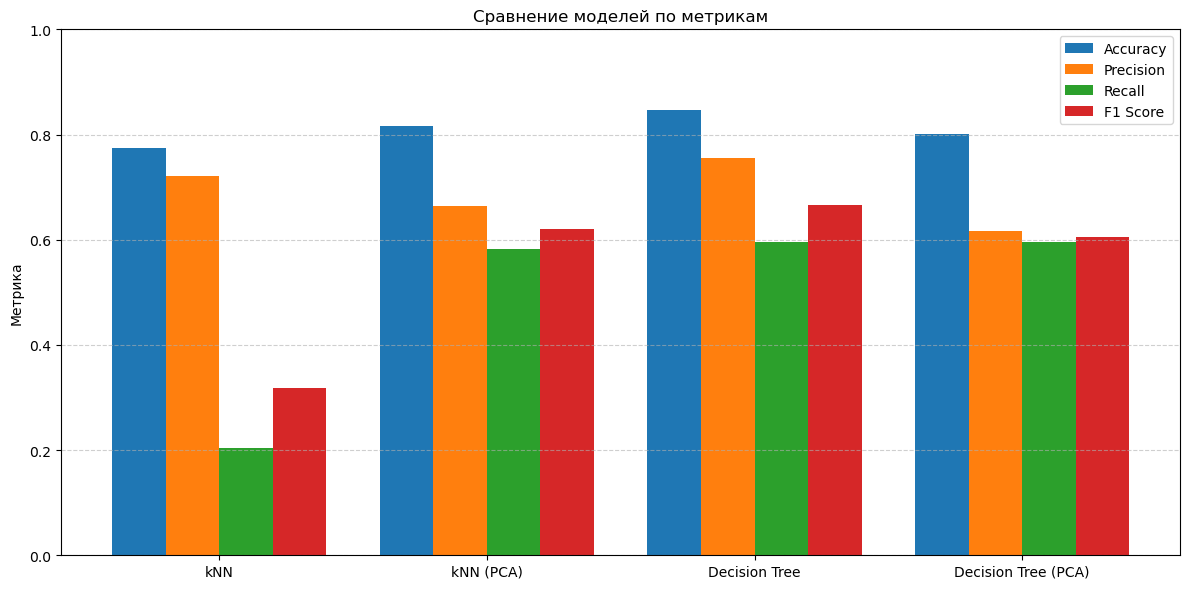

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Метрики всех моделей
labels = ["kNN", "kNN (PCA)", "Decision Tree", "Decision Tree (PCA)"]

accuracy = [0.775, 0.817, 0.847, 0.801]
precision = [0.721, 0.664, 0.756, 0.617]
recall = [0.204, 0.582, 0.595, 0.596]
f1 = [0.318, 0.620, 0.666, 0.606]

x = np.arange(len(labels))
width = 0.2  # ширина столбца

# Построение группированной диаграммы
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1, width, label='F1 Score')

# Подписи
ax.set_ylabel('Метрика')
ax.set_title('Сравнение моделей по метрикам')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


График выше показывает значения четырёх ключевых метрик (`accuracy`, `precision`, `recall`, `f1`) для всех протестированных моделей:

- **Decision Tree (без PCA)** демонстрирует наилучшие показатели по всем метрикам, особенно по `accuracy` и `f1`, что делает её финальным победителем.
- **kNN с PCA** показал себя намного лучше, чем без PCA — особенно заметен рост `recall` и `f1`.
- **Decision Tree с PCA** сохраняет высокий `recall`, но теряет в `precision` и `accuracy`.
- **kNN без PCA** оказался наименее эффективным — особенно слабый `recall`, что означает плохое выявление положительного класса (`>50K`).

#### Визуализация подтверждает вывод: **Decision Tree без PCA** — лучший выбор для решения данной задачи.
